# Chapter: State-Space Models: Efficient Modeling of MIMO Systems


## Topic: Monitoring industrial chemical plant via CVA

In [1]:
# import packages 
import matplotlib.pyplot as plt, numpy as np
from sklearn.preprocessing import StandardScaler

# package settings
plt.rcParams.update({'font.size': 20})

In [2]:
# read training and faulty/test data
trainingData = np.loadtxt('d00.dat').T
FaultyData =  np.loadtxt('d05_te.dat')

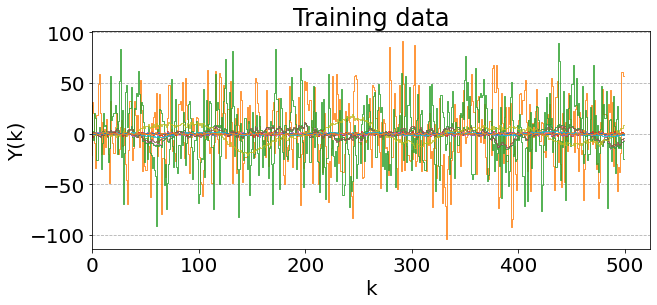

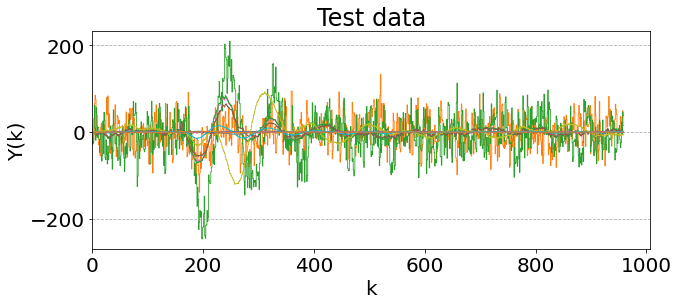

In [4]:
# separate inputs and outputs in datasets
uData_training, yData_training = trainingData[:,41:52], trainingData[:,0:22]
uData_test, yData_test = FaultyData[:,41:52], FaultyData[:,0:22]

# center data for plotting
y_scaler = StandardScaler(with_std=False)
yData_training_centered = y_scaler.fit_transform(yData_training) 
yData_test_centered = y_scaler.transform(yData_test) 

plt.figure(figsize=(10,4))
plt.plot(yData_training_centered, linewidth=0.8, drawstyle='steps')
plt.ylabel('Y(k)'), plt.xlabel('k'), plt.xlim(0), plt.title('Training data')
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(10,4))
plt.plot(yData_test_centered, linewidth=0.8, drawstyle='steps')
plt.ylabel('Y(k)'), plt.xlabel('k'), plt.xlim(0), plt.title('Test data')
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

In [5]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##    generate past (p) and future (f) vectors for training dataset and center them
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
N = trainingData.shape[0]
l = 3
m = uData_training.shape[1]
r = yData_training.shape[1]

pMatrix_train = np.zeros((N-2*l, l*(m+r)))
fMatrix_train = np.zeros((N-2*l, (l+1)*r))
for i in range(l,N-l):
    pMatrix_train[i-l,:] = np.hstack((yData_training[i-l:i,:].flatten(), uData_training[i-l:i,:].flatten()))
    fMatrix_train[i-l,:] = yData_training[i:i+l+1,:].flatten()

# center data
p_scaler = StandardScaler(with_std=False); pMatrix_train_centered = p_scaler.fit_transform(pMatrix_train)
f_scaler = StandardScaler(with_std=False); fMatrix_train_centered = f_scaler.fit_transform(fMatrix_train) 

In [6]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                        perform SVD
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
import scipy 

sigma_pp = np.cov(pMatrix_train_centered, rowvar=False)
sigma_ff = np.cov(fMatrix_train_centered, rowvar=False)
sigma_pf = np.cov(pMatrix_train_centered, fMatrix_train_centered, rowvar=False)[:len(sigma_pp),len(sigma_pp):]

matrixProduct = np.dot(np.dot(np.linalg.inv(scipy.linalg.sqrtm(sigma_pp).real), sigma_pf), np.linalg.inv(scipy.linalg.sqrtm(sigma_ff).real))
U, S, V = np.linalg.svd(matrixProduct)
J = np.dot(np.transpose(U), np.linalg.inv(scipy.linalg.sqrtm(sigma_pp).real))

In [7]:
# get the reduced order matrices
n = 29
Jn = J[:n,:]
Je = J[n:,:]

In [8]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##             get fault detection metrics for training data
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Ts2
Xn_train = np.dot(Jn, pMatrix_train_centered.T)
Ts2_train = [np.dot(Xn_train[:,i], Xn_train[:,i]) for i in range(pMatrix_train_centered.shape[0])] 

# Te2
Xe_train = np.dot(Je, pMatrix_train_centered.T)
Te2_train = [np.dot(Xe_train[:,i], Xe_train[:,i]) for i in range(pMatrix_train_centered.shape[0])] 

# Q
r_train = pMatrix_train_centered.T - np.dot(Jn.T, Xn_train)
Q_train = [np.dot(r_train[:,i], r_train[:,i]) for i in range(pMatrix_train_centered.shape[0])] 

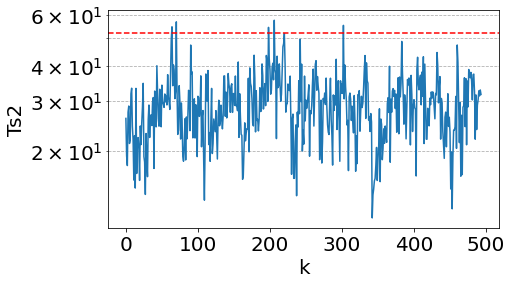

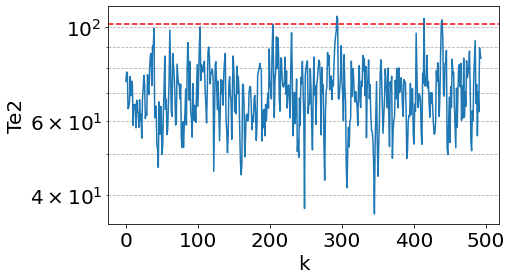

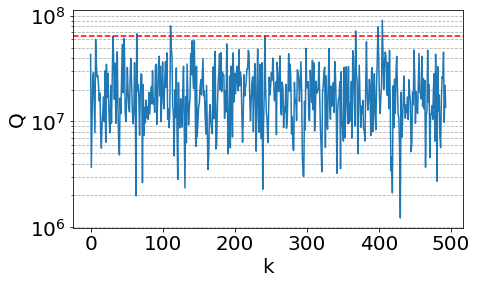

In [9]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##              Control Limits (99 percentile empirical approach)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Ts2_CL = np.percentile(Ts2_train, 99)
Te2_CL = np.percentile(Te2_train, 99)
Q_CL = np.percentile(Q_train, 99)

plt.figure(figsize=(7,4))
plt.plot(Ts2_train)
plt.axhline(Ts2_CL, color = "red", linestyle = "--")
plt.ylabel('Ts2'), plt.xlabel('k'), plt.yscale('log')
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(7,4))
plt.plot(Te2_train)
plt.axhline(Te2_CL, color = "red", linestyle = "--")
plt.ylabel('Te2'), plt.xlabel('k'), plt.yscale('log')
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(7,4))
plt.plot(Q_train)
plt.axhline(Q_CL, color = "red", linestyle = "--")
plt.ylabel('Q'), plt.xlabel('k'), plt.yscale('log')
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

In [10]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##    generate past vectors for test dataset and center them
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Ntest = FaultyData.shape[0]

pMatrix_test = np.zeros((Ntest-l+1, l*(m+r)))
for i in range(l,Ntest+1):
    pMatrix_test[i-l,:] = np.hstack((yData_test[i-l:i,:].flatten(), uData_test[i-l:i,:].flatten()))

pMatrix_test_centered = p_scaler.transform(pMatrix_test)

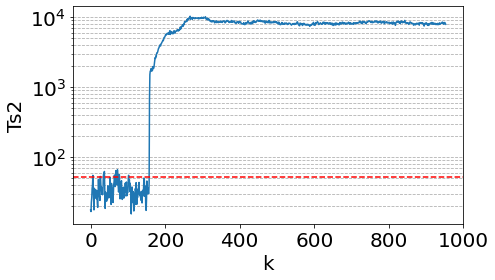

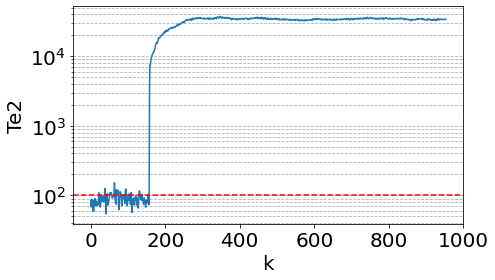

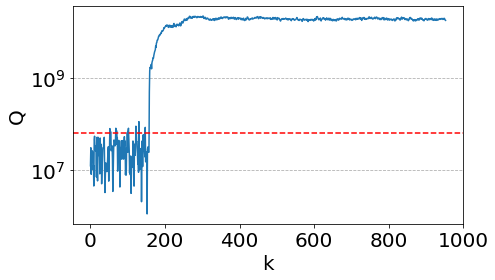

In [11]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                        get control metrics for test data
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Ts2
Xn_test = np.dot(Jn, pMatrix_test_centered.T)
Ts2_test = [np.dot(Xn_test[:,i], Xn_test[:,i]) for i in range(pMatrix_test_centered.shape[0])] 

plt.figure(figsize=(7,4))
plt.plot(Ts2_test)
plt.axhline(Ts2_CL, color = "red", linestyle = "--")
plt.ylabel('Ts2'), plt.xlabel('k'), plt.yscale('log')
plt.grid(which='both', axis='y', linestyle='--')

# Te2
Xe_test = np.dot(Je, pMatrix_test_centered.T)
Te2_test = [np.dot(Xe_test[:,i], Xe_test[:,i]) for i in range(pMatrix_test_centered.shape[0])] 

plt.figure(figsize=(7,4))
plt.plot(Te2_test)
plt.axhline(Te2_CL, color = "red", linestyle = "--")
plt.ylabel('Te2'), plt.xlabel('k'), plt.yscale('log')
plt.grid(which='both', axis='y', linestyle='--')

# Q
r_test = pMatrix_test_centered.T - np.dot(Jn.T, Xn_test)
Q_test = [np.dot(r_test[:,i], r_test[:,i]) for i in range(pMatrix_test_centered.shape[0])] 

plt.figure(figsize=(7,4))
plt.plot(Q_test)
plt.axhline(Q_CL, color = "red", linestyle = "--")
plt.ylabel('Q'), plt.xlabel('k'), plt.yscale('log')
plt.grid(which='both', axis='y', linestyle='--')